In [1]:
import sys; sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')
import pickle

from glob import glob
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
from src.evaluation import imbalanced_score, matthews_corrcoef_score

from sklearn.metrics import classification_report

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier, RandomForestClassifier)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from xgboost import XGBClassifier

from src.oversampling import G_SMOTEDecorator
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest, mutual_info_classif

from glob import glob

def extract_configuration(path):
    
    with open(path, 'rb') as f:
        conf = pickle.load(f)
    
    return {
        key.split('__')[-1]: val
        for key, val in conf.items()
    }


Using TensorFlow backend.


In [2]:
X = pd.read_csv('../data/all_X.csv')
y = pd.read_csv('../data/all_y.csv', header=None).T.ix[0]

X_castell = pd.read_csv('../data/castellX.csv')
y_castell = pd.read_csv('../data/castelly.csv', header=None).T.ix[0]

2019-12-13 20:26:03,113:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-13 20:26:12,742:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-13 20:26:16,424:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-13 20:26:19,953:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-13 20:27:34,549:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}")
2019-12-13 20:27:46,623:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': None}"

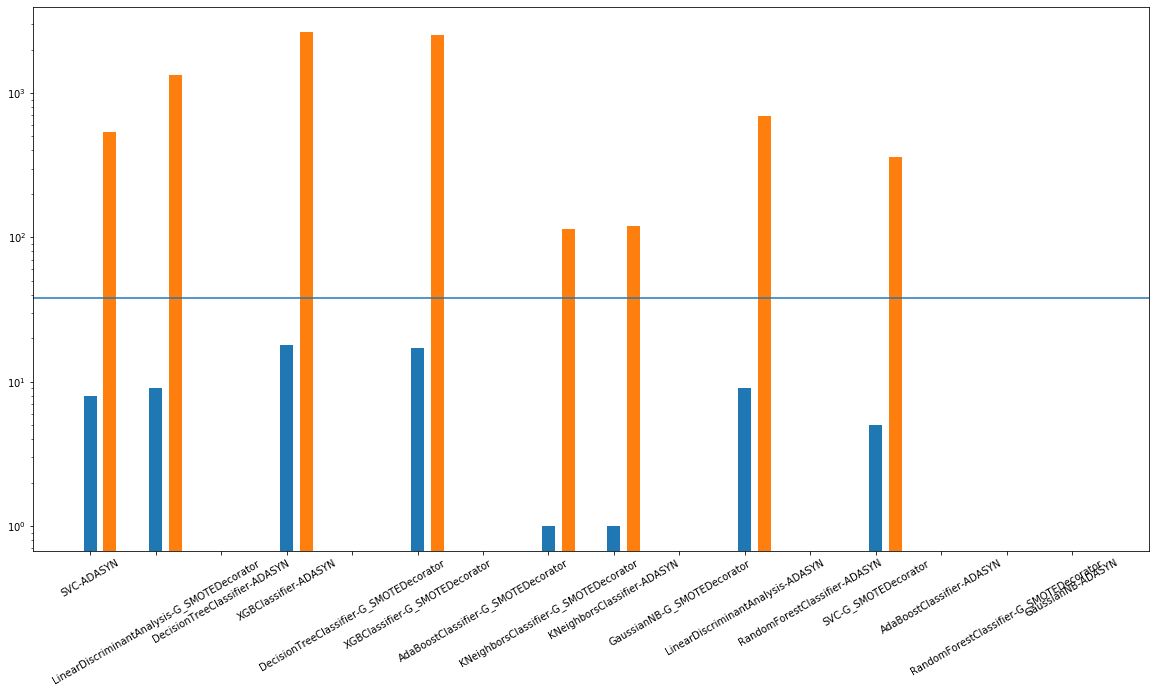

In [3]:
ts, tps, gts, labels = [], [], [], []

for path in glob('../experiments/feature_selection/results/*[!ts].pickle'):
    path = Path(path)
    model_name, oversampler_name = path.name[:-len('.pickle')].split('-')
    
    feat_conf = extract_configuration(path)
    model_conf = extract_configuration(f'{path.parent.parent.parent}/model_selection/results/{path.name}')
    
    
    model = eval(model_name)(**model_conf)
    feature_selector = SelectKBest(mutual_info_classif, **feat_conf)
    oversampler = eval(oversampler_name)()
    clf = Pipeline([
        ('OVERSAMPLER', oversampler),
        ('FEATURE_SELECTION', feature_selector),
        (model.__class__.__name__, model)
    ])
    
    clf.fit(X, y)
    y_pred = clf.predict(X_castell)
    ts.append(sum(y_pred))
    tps.append(sum(y_pred & y_castell))
    gts.append(sum(y_castell))
    labels.append(f'{model_name}-{oversampler_name}')
plt.figure(figsize=(20,10))
x = np.arange(len(tps))

plt.bar(x, tps, width=0.2)
plt.bar(x + 0.3, ts, width=0.2)

plt.xticks(x, labels, rotation=30)
plt.yscale('log')
plt.axhline(gts[0])